# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [1]:
!pip install catboost

In [2]:
# Подключения библиотек
import os
import random
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# импортируем библиотеки для работы с progress bar
from tqdm import *
from tqdm.notebook import tqdm
tqdm.pandas()

# Импортируем модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor

# Импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# Импортируем pytorch
import torch
import torch.nn as nn

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('CPU')

CPU


Зафиксируем `RANDOM_STATE`

In [6]:
RANDOM_STATE = 170125
set_seed(RANDOM_STATE)

Random seed set as 170125


## Шаг 1. Загрузка данных

Данные хранятся в `Sqlite`  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk`_time — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

In [7]:
DB_FILENAME = 'ds-plus-final.db'

In [8]:
def download_file(url, filename):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(filename, 'wb') as f:
          pbar = tqdm(total=int(r.headers['Content-Length']))
          for chunk in r.iter_content(chunk_size=8192):
              if chunk:
                  f.write(chunk)
                  pbar.update(len(chunk))

In [9]:
if not os.path.isfile(DB_FILENAME):
    download_file('https://code.s3.yandex.net/data-scientist/ds-plus-final.db', DB_FILENAME)

Объявим учетные данные для подключения к базе данных

In [10]:
engine = create_engine(f'sqlite:///{DB_FILENAME}', echo=False) 

In [11]:
def primary_table_information(engine, table, limit):
    select_10_query = '''
    SELECT *
    FROM {}
    LIMIT {}
    '''
    count_all_query = '''
    SELECT COUNT(*)
    FROM {}
    '''
    printmd(f"Количество строк: {pd.read_sql_query(count_all_query.format(table), con = engine)['COUNT(*)'][0]}")
    df = pd.read_sql_query(select_10_query.format(table, limit), con = engine)
    display(df.head(limit))

### Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

In [12]:
primary_table_information(engine, 'data_arc', 10)

Количество строк: 14876

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


### Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1 … Bulk15` — объём подаваемого материала.

In [13]:
primary_table_information(engine, 'data_bulk', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,None,None,None,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,None,None,None,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,None,None,None,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


### Таблица `steel.data_bulk_time`
- `key` — номер партии;
- `Bulk1 … Bulk15` — время подачи материала.

In [14]:
primary_table_information(engine, 'data_bulk_time', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,None,None,None,2019-05-03 13:57:27,None,None,None,None,None,None,None,2019-05-03 13:48:52,None,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,None,None,None,2019-05-03 14:18:58,None,None,None,None,None,None,None,2019-05-03 14:41:26,None,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,None,None,None,2019-05-03 15:17:58,None,None,None,None,None,None,None,2019-05-03 15:17:58,None,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,None,None,None,2019-05-03 16:03:08,None,None,None,None,None,None,None,2019-05-03 16:03:08,None,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,None,None,None,None,None,None,None,None,None,None,None,2019-05-03 16:38:11,None,2019-05-03 16:34:24,2019-05-03 16:29:56


### Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.

In [15]:
primary_table_information(engine, 'data_gas', 10)

Количество строк: 3239

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


### Таблица steel.data_temp
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

In [16]:
primary_table_information(engine, 'data_temp', 10)

Количество строк: 18092

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


### Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1 … Wire9` — объём подаваемых проволочных материалов.

In [17]:
primary_table_information(engine, 'data_wire', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


### Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1 … Wire9` — время подачи проволочных материалов.

In [18]:
primary_table_information(engine, 'data_wire_time', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Объем данных позволяет загрузить их в DataFrame

## Шаг 2. Исследовательский анализ и предобработка данных

In [20]:
def draw_boxplots(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);

In [21]:
def draw_hists(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        df[cols[i]].hist(ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);
    return fig, axs

In [124]:
def primary_info(df, limit=5):
    display(df.head(limit))
    display(df.info())
    printmd("**Пропущенные значения**")
    display(df.isna().sum())
    printmd(f"**Количество дубликатов: {df.duplicated().sum()}**")

### Проанализируйте исходные данные. Проверьте:
- Все ли таблицы содержат данные.
- Соответствует ли количество таблиц условию задачи.

### Для таблицы steel.data_arc:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Вам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.
- Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.
- При агрегировании наблюдений по ключу учитывайте порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.

In [336]:
data_arc_df = pd.read_sql_query("SELECT * FROM data_arc", con = engine)

In [337]:
primary_info(data_arc_df)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

**Пропущенные значения**

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

**Количество дубликатов: 0**

Пропущенных значений и дубликатов нет. Сгенерируем дополнительные признаки

In [338]:
# Переименуем столбцы
data_arc_df.rename(inplace=True, columns={
    "Начало нагрева дугой": "start_heat_time", 
    "Конец нагрева дугой": "stop_heat_time", 
    "Активная мощность": "active_power", 
    "Реактивная мощность": "reactive_power"
})

# Приведем дату к типу datatime
data_arc_df['start_heat_time'] = pd.to_datetime(data_arc_df['start_heat_time'], format="%Y-%m-%d %H:%M:%S")
data_arc_df['stop_heat_time'] = pd.to_datetime(data_arc_df['stop_heat_time'], format="%Y-%m-%d %H:%M:%S")

Добавим новые признаки:
- Длительность нагрева
- Суммарная мощность
- Отношение мощностей `Реактивная мощность/Активная мощность`

In [339]:
data_arc_df['heat_delta_seconds'] = (data_arc_df['stop_heat_time']-data_arc_df['start_heat_time']).dt.seconds
data_arc_df['total_power'] = (data_arc_df['active_power']+data_arc_df['reactive_power'])
data_arc_df['power_ratio'] = (data_arc_df['reactive_power']/data_arc_df['active_power'])

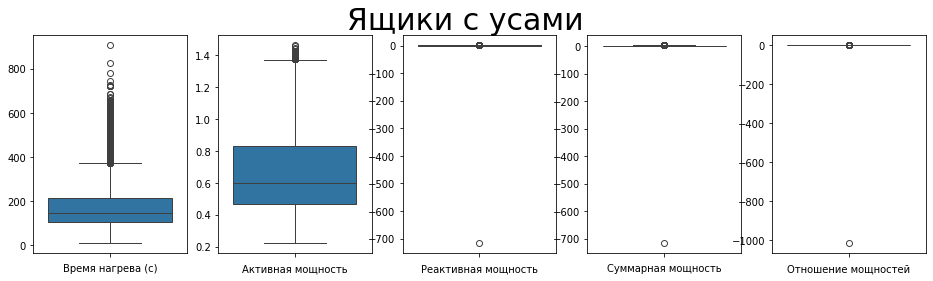

In [340]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")

In [341]:
key = data_arc_df[data_arc_df['reactive_power'] < 0]['key']
data_arc_df = data_arc_df[~data_arc_df['key'].isin(key)]

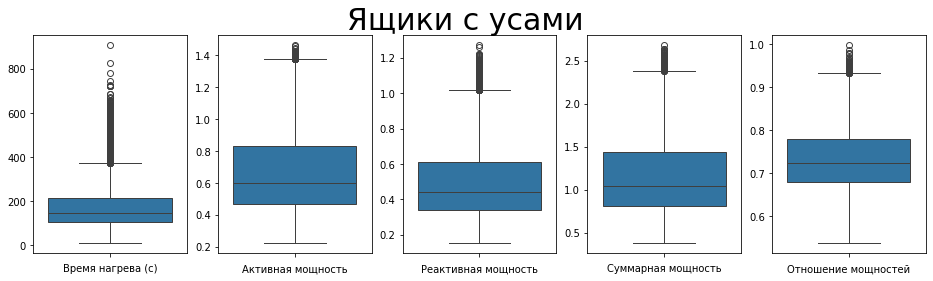

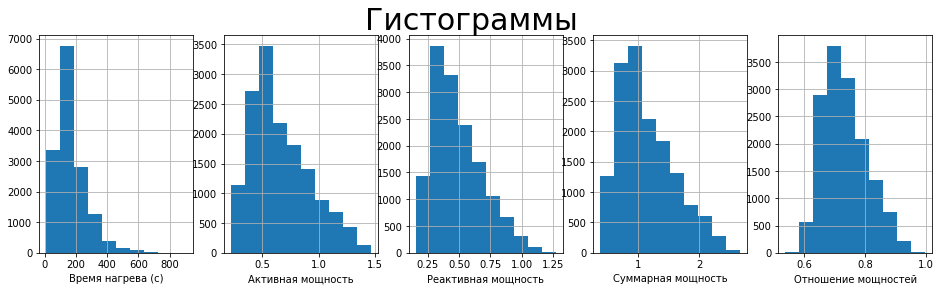

In [342]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")
draw_hists(data_arc_df, 
           ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
           ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
            'Суммарная мощность', 'Отношение мощностей'],
           "Гистограммы");

In [343]:
data_arc_df = data_arc_df.groupby('key').agg({
    'heat_delta_seconds': ['sum', 'mean'],
    'active_power': 'sum',
    'reactive_power': 'sum',
    'total_power': 'sum',
    'power_ratio': 'mean', 
    'key': 'count'
})
data_arc_df.columns = [col[0] + "_" + col[1] for col in data_arc_df.columns]

In [344]:
data_arc_df.head()

,heat_delta_seconds_sum,heat_delta_seconds_mean,active_power_sum,reactive_power_sum,total_power_sum,power_ratio_mean,key_count
key,,,,,,,
1,1098,219.60,3.036730,2.142821,5.179551,0.706569,5
2,811,202.75,2.139408,1.453357,3.592765,0.684080,4
3,655,131.00,4.063641,2.937457,7.001098,0.725034,5
4,741,185.25,2.706489,2.056992,4.763481,0.765897,4
5,869,217.25,2.252950,1.687991,3.940941,0.758599,4


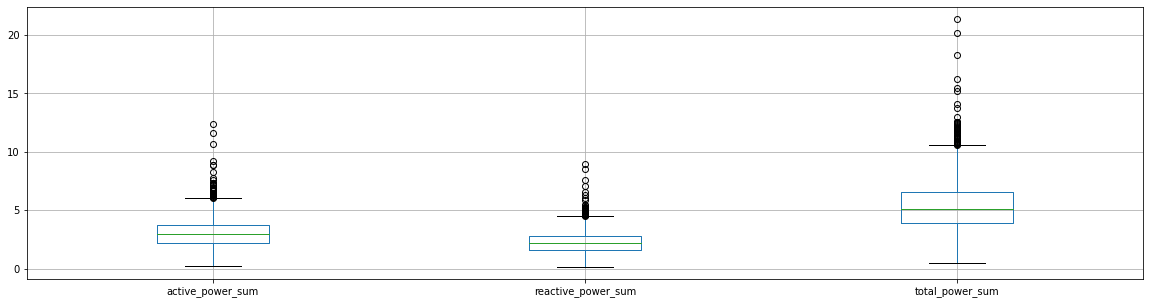

In [345]:
data_arc_df.boxplot(column=['active_power_sum', 'reactive_power_sum', 'total_power_sum'], figsize=(20, 5));

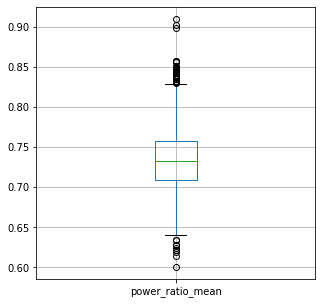

In [346]:
data_arc_df.boxplot(column=['power_ratio_mean'], figsize=(5, 5));

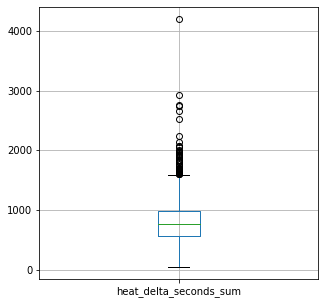

In [347]:
data_arc_df.boxplot(column=['heat_delta_seconds_sum'], figsize=(5, 5));

### Для таблицы steel.data_bulk:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Обработайте пропуски. Пропуск означает, что материал не добавляли в партию.

In [349]:
data_bulk_df = pd.read_sql_query("SELECT * FROM data_bulk", index_col='key', con = engine)

In [350]:
primary_info(data_bulk_df)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     object 
 5   Bulk 6   576 non-null    object 
 6   Bulk 7   25 non-null     object 
 7   Bulk 8   1 non-null      object 
 8   Bulk 9   19 non-null     object 
 9   Bulk 10  176 non-null    object 
 10  Bulk 11  177 non-null    object 
 11  Bulk 12  2450 non-null   object 
 12  Bulk 13  18 non-null     object 
 13  Bulk 14  2806 non-null   object 
 14  Bulk 15  2248 non-null   object 
dtypes: float64(4), object(11)
memory usage: 391.1+ KB


None

**Пропущенные значения**

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Количество дубликатов: 80**

In [352]:
bulk_idx = list([f"bulk_{x}" for x in range(1, 16)])

# Переименуем столбцы
data_bulk_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу float64
data_bulk_df[bulk_idx] = data_bulk_df[bulk_idx].astype('float64')

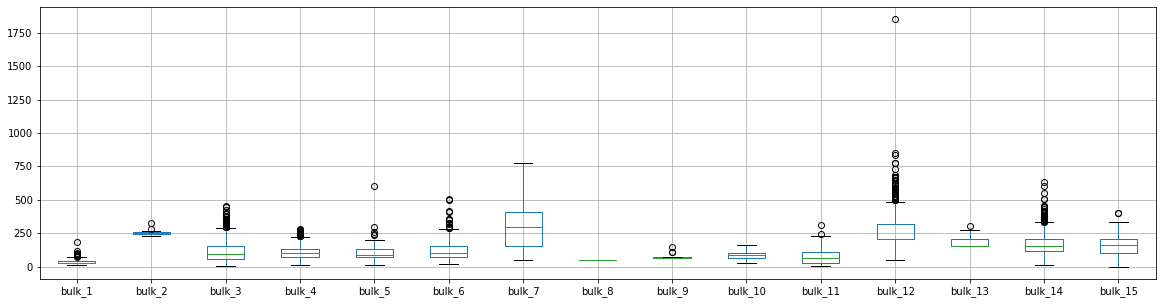

In [353]:
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

Удалим аномальные значения в `bulk_12 > 1000` и `bulk_5 > 500`

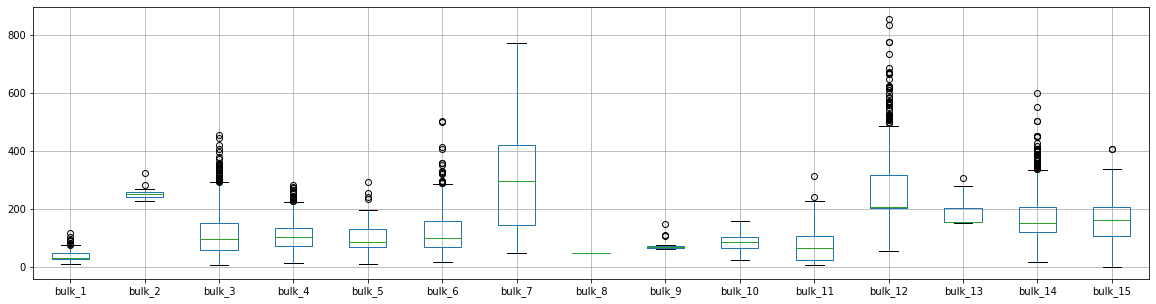

In [354]:
key = data_bulk_df[(data_bulk_df['bulk_5'] > 500) | (data_bulk_df['bulk_12'] > 1000)].index
data_bulk_df = data_bulk_df.drop(key)
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

In [355]:
data_bulk_df = data_bulk_df.fillna(0)
data_bulk_df.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Для таблицы steel.data_bulk_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [411]:
data_bulk_time_df = pd.read_sql_query("SELECT * FROM data_bulk_time", index_col='key', con = engine)

In [412]:
primary_info(data_bulk_time_df)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bulk 1   252 non-null    object
 1   Bulk 2   22 non-null     object
 2   Bulk 3   1298 non-null   object
 3   Bulk 4   1014 non-null   object
 4   Bulk 5   77 non-null     object
 5   Bulk 6   576 non-null    object
 6   Bulk 7   25 non-null     object
 7   Bulk 8   1 non-null      object
 8   Bulk 9   19 non-null     object
 9   Bulk 10  176 non-null    object
 10  Bulk 11  177 non-null    object
 11  Bulk 12  2450 non-null   object
 12  Bulk 13  18 non-null     object
 13  Bulk 14  2806 non-null   object
 14  Bulk 15  2248 non-null   object
dtypes: object(15)
memory usage: 391.1+ KB


None

**Пропущенные значения**

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Количество дубликатов: 0**

In [413]:
# Переименуем столбцы
data_bulk_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу datetime
data_bulk_time_df[bulk_idx] = data_bulk_time_df[bulk_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

In [414]:
def calc_delta(x):
    tt = [value for value in x if not pd.isnull(value)]
    return (max(tt)-min(tt)).seconds

In [415]:
def calc_mean_delta(x):
    tt = sorted([value for value in x if not pd.isnull(value)])
    p = tt[0]
    r_val = []
    for n in tt[1:]:
        r_val.append((n-p).seconds)
        p = n
    if len(r_val) == 0:
        return 0
    return sum(r_val)/len(r_val)

  0%|          | 0/3129 [00:00<?, ?it/s]

<Axes: >

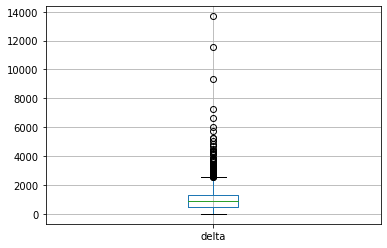

In [416]:
data_bulk_time_df['delta'] = data_bulk_time_df[bulk_idx].progress_apply(calc_delta, axis=1)
data_bulk_time_df[['delta']].boxplot()

  0%|          | 0/3129 [00:00<?, ?it/s]

<Axes: >

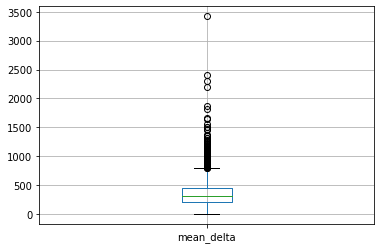

In [417]:
data_bulk_time_df['mean_delta'] = data_bulk_time_df[bulk_idx].progress_apply(calc_mean_delta, axis=1)
data_bulk_time_df[['mean_delta']].boxplot()

In [418]:
data_bulk_time_df[data_bulk_time_df['mean_delta'] > 1500]

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,delta,mean_delta
key,,,,,,,,,,,,,,,,,
87,NaT,NaT,NaT,NaT,NaT,2019-05-06 17:43:26,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-06 17:18:17,NaT,1509,1509.000000
114,NaT,2019-05-07 16:16:34,NaT,NaT,2019-05-07 16:46:56,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1822,1822.000000
461,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-21 03:31:46,NaT,2019-05-21 03:25:53,NaT,2019-05-21 03:18:46,2019-05-21 02:13:39,4687,1562.333333
829,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-04 20:52:39,NaT,2019-06-04 20:44:52,2019-06-04 19:57:36,3303,1651.500000
1880,NaT,NaT,2019-07-12 10:21:30,NaT,NaT,2019-07-12 10:13:21,NaT,NaT,NaT,NaT,2019-07-12 09:06:13,2019-07-12 08:06:14,NaT,2019-07-12 07:52:20,2019-07-12 07:45:54,9336,1867.200000
1881,NaT,NaT,2019-07-12 13:55:14,NaT,NaT,2019-07-12 13:48:37,NaT,NaT,NaT,NaT,2019-07-12 13:43:25,2019-07-12 13:28:04,NaT,2019-07-12 10:56:50,2019-07-12 10:42:42,11552,2310.400000
1958,NaT,NaT,2019-07-21 14:44:03,NaT,NaT,2019-07-21 14:39:15,NaT,NaT,NaT,NaT,NaT,2019-07-21 14:31:46,NaT,2019-07-21 14:27:11,2019-07-21 10:56:00,13683,3420.750000
2562,2019-08-12 19:51:09,2019-08-12 21:42:20,NaT,2019-08-12 21:23:19,2019-08-12 21:20:02,NaT,2019-08-12 20:24:56,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,6671,1667.750000
2673,NaT,NaT,NaT,NaT,NaT,2019-08-17 02:57:31,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-17 02:20:50,NaT,2201,2201.000000


### Для таблицы steel.data_gas:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

In [364]:
data_gas_df = pd.read_sql_query("SELECT * FROM data_gas", index_col='key', con = engine)

In [365]:
primary_info(data_gas_df)

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


None

**Пропущенные значения**

Газ 1    0
dtype: int64

**Количество дубликатов: 0**

In [367]:
# Переименуем столбцы
data_gas_df.rename(inplace=True, columns={'Газ 1': 'gas'})

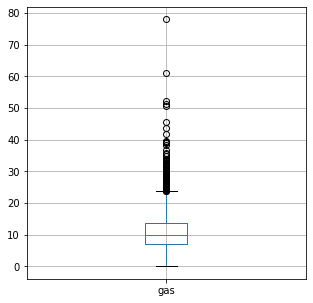

In [368]:
data_gas_df.boxplot(column='gas', figsize=(5, 5));

### Для таблицы steel.data_temp:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределения признаков.
- Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
- При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
- Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [386]:
data_temp_df = pd.read_sql_query("SELECT * FROM data_temp", con = engine)

In [387]:
primary_info(data_temp_df, 10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


None

**Пропущенные значения**

key                0
Время замера       0
Температура     3427
dtype: int64

**Количество дубликатов: 0**

In [388]:
data_temp_df.rename(inplace=True, columns={
    "Время замера": "measure_time", 
    "Температура": "temperature"
})

In [389]:
# Приведем дату к типу datatime
data_temp_df['measure_time'] = pd.to_datetime(
    data_temp_df['measure_time'], format="%Y-%m-%d %H:%M:%S"
)
# Приведем температуру к типу float64
data_temp_df['temperature'] = data_temp_df['temperature'].astype('float64')

In [390]:
# Удалим записи с значениями температуры ниже 1500 градусов
data_temp_df = data_temp_df[data_temp_df['temperature'] > 1500]

In [391]:
data_temp_df = data_temp_df.groupby('key').agg(['first', 'last', 'count'])
data_temp_df.columns = [col[0] + "_" + col[1] for col in data_temp_df.columns]

In [392]:
# Оставим записи с количеством наблюдений более двух
data_temp_df = data_temp_df[data_temp_df['temperature_count'] > 1]

In [393]:
primary_info(data_temp_df, 10)

,measure_time_first,measure_time_last,measure_time_count,temperature_first,temperature_last,temperature_count
key,,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,6,1571.0,1613.0,6
2,2019-05-03 11:34:04,2019-05-03 11:55:09,5,1581.0,1602.0,5
3,2019-05-03 12:06:44,2019-05-03 12:35:57,6,1596.0,1599.0,6
4,2019-05-03 12:39:27,2019-05-03 12:59:47,5,1601.0,1625.0,5
5,2019-05-03 13:11:03,2019-05-03 13:36:39,5,1576.0,1602.0,5
6,2019-05-03 13:46:41,2019-05-03 14:11:38,5,1543.0,1596.0,5
7,2019-05-03 14:16:36,2019-05-03 14:45:40,5,1586.0,1599.0,5
8,2019-05-03 14:53:46,2019-05-03 15:20:41,5,1577.0,1598.0,5
9,2019-05-03 15:36:33,2019-05-03 16:06:44,6,1587.0,1592.0,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   measure_time_first  2475 non-null   datetime64[ns]
 1   measure_time_last   2475 non-null   datetime64[ns]
 2   measure_time_count  2475 non-null   int64         
 3   temperature_first   2475 non-null   float64       
 4   temperature_last    2475 non-null   float64       
 5   temperature_count   2475 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.4 KB


None

**Пропущенные значения**

measure_time_first    0
measure_time_last     0
measure_time_count    0
temperature_first     0
temperature_last      0
temperature_count     0
dtype: int64

**Количество дубликатов: 0**

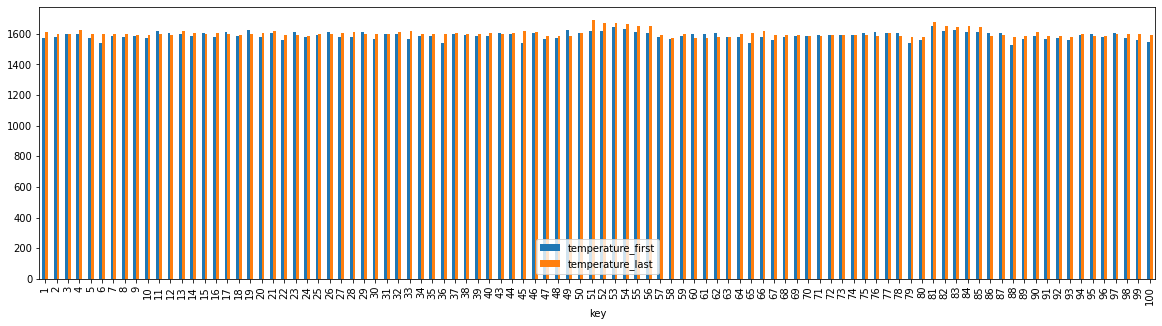

In [395]:
data_temp_df.loc[:100][['temperature_first', 'temperature_last']].plot(kind='bar', figsize=(20,5));

### Для таблицы steel.data_wire:
- Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию.

In [396]:
data_wire_df = pd.read_sql_query("SELECT * FROM data_wire", index_col='key', con = engine)

In [401]:
primary_info(data_wire_df)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3081 non-null   float64
 1   wire_2  3081 non-null   float64
 2   wire_3  3081 non-null   float64
 3   wire_4  3081 non-null   float64
 4   wire_5  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


None

**Пропущенные значения**

wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

**Количество дубликатов: 403**

In [398]:
wire_idx = list([f"wire_{x}" for x in range(1, 10)])

# Переименуем столбцы
data_wire_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Преобразуем к типу float64
data_wire_df[wire_idx] = data_wire_df[wire_idx].astype('float64')

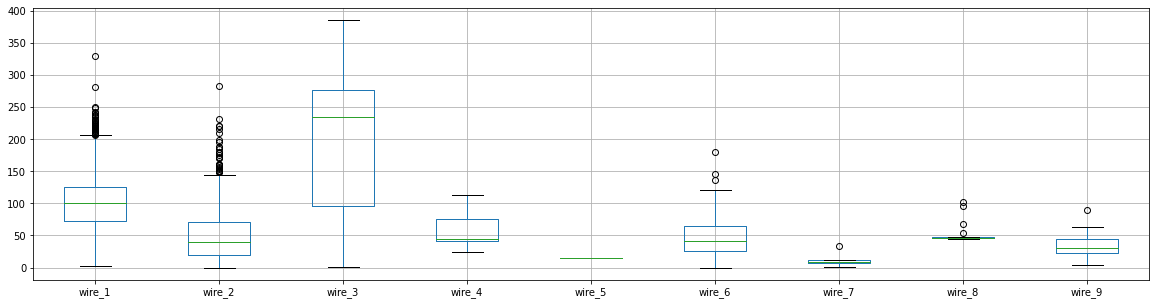

In [399]:
data_wire_df.boxplot(column=wire_idx, figsize=(20, 5));

In [400]:
data_wire_df = data_wire_df.fillna(0)
data_wire_df.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Для таблицы steel.data_wire_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [225]:
data_wire_time_df = pd.read_sql_query("SELECT * FROM data_wire_time", con = engine)

In [226]:
primary_info(data_wire_time_df)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

**Пропущенные значения**

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Количество дубликатов: 0**

In [227]:
# Переименуем столбцы
data_wire_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Приведем к типу datetime
data_wire_time_df[wire_idx] = data_wire_time_df[wire_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

  0%|          | 0/3081 [00:00<?, ?it/s]

<Axes: >

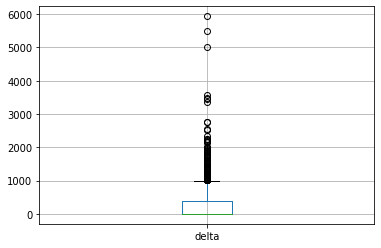

In [419]:
data_wire_time_df['delta'] = data_wire_time_df[wire_idx].progress_apply(calc_delta, axis=1)
data_wire_time_df[['delta']].boxplot()

### Объедините таблицы по ключу:
- Каждой партии должно соответствовать одно наблюдение.
- Учтите: во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
- Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков. Если вы будете выстраивать хронологию процессов для разных партий, то можете столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.
- Проведите исследовательский анализ данных объединённой таблицы и визуализируйте распределение каждого признака, напишите выводы.
- Проведите корреляционный анализ.

### Подготовьте данные для обучения:
- Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей.
- Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
- Подготовьте выборки для обучения, учитывайте особенности выбранных моделей.

## Шаг 3. Обучение модели

### Решающее дерево или случайный лес

### Бустинги

### Нейронные сети

## Шаг 4. Тестирование модели и демонстрация её работы

## Шаг 5. Общий вывод по работе